In [32]:
# data manipulation
from utils import save, load
import pandas as pd

# modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline

In [5]:
train_df = load('train')
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66.0,57.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51.0,88.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73.0,59.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50.0,65.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76.0,39.0


Let's make a stack of questions maintaining the `id` of the question pair.

In [6]:
question_df = train_df.loc[:, ['id', 'question1']]
question_df = question_df.append(train_df.loc[:,['id', 'question2']], sort=False)
question_df.loc[question_df['question1'].isna(), 'question1'] = question_df.loc[question_df['question1'].isna(), 'question2']
question_df = question_df.drop(columns='question2')
question_df = question_df.sort_values('id')
question_df.head(6)

,id,question1
0,0,What is the step by step guide to invest in sh...
0,0,What is the step by step guide to invest in sh...
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...
1,1,What would happen if the Indian government sto...
2,2,How can I increase the speed of my internet co...
2,2,How can Internet speed be increased by hacking...


Let's now calcualte the tf-idf term matrix.

In [7]:
tf = TfidfVectorizer()

question_tf = tf.fit_transform(question_df['question1'])

In [8]:
# first 10 terms
tf.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '000000',
 '00000000',
 '0000000000',
 '0000001',
 '00000074',
 '0000021210',
 '00001']

In [9]:
# last 10 terms
tf.get_feature_names()[-10:]

['분위기', '불타오르네', '슬마', '심하잖아', '이정현', '친구해도', '쾌지나칭칭나네', '하지만', '한글', 'ﬁnd']

In [10]:
# total terms
len(tf.get_feature_names())

86149

Lots of words, but some cleanup will probably needed given the numbers, and what appears to be Korean characters.

Let's now transform the 86,150 into a 20 dimension matrix with NMF

In [11]:
nmf = NMF(n_components=20)

question_nmf = nmf.fit_transform(question_tf)

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [13]:
print_top_words(nmf, tf.get_feature_names(), 10)

Topic #0: of the what meaning most world all was life rid
Topic #1: do how get people become with think start from find
Topic #2: are some what ways good examples that about things books
Topic #3: you have if ever would think when thing that know
Topic #4: to way learn want ways get need from lose weight
Topic #5: it like be possible feel an at to with that
Topic #6: why people so not we do did don many and
Topic #7: in india the world there engineering where life job which
Topic #8: can how get where we find one learn be become
Topic #9: is what the way thing there or most better an
Topic #10: and between difference the 500 notes 1000 what differences rupee
Topic #11: my improve english account skills me password if gmail increase
Topic #12: for prepare good year 2017 exam an free book engineering
Topic #13: on quora questions question ask answer answers google asked delete
Topic #14: does mean how work what have feel much one long
Topic #15: money make online earn from ways how 1000 

We now have mapped the term matrix into a 20 topic space. Let's now calculate the `cosine_similarity` between each pair of questions. The goal is to determine if `cosine_similarity` will indicate whether or not the pair of questions have the same intent.

In [14]:
odd_idx = [i for i in range(question_nmf.shape[0]) if i % 2 == 1]
even_idx = [i for i in range(question_nmf.shape[0]) if i % 2 == 0]
print(len(odd_idx))
train_df.shape[0]

404266


404266

In [15]:
# takes a long time...probably a better way to do this calculation
sim_list = []
for i in range(len(odd_idx)):
    q1 = question_nmf[odd_idx[i]].reshape(1,-1)
    q2 = question_nmf[even_idx[i]].reshape(1,-1)
    sim = cosine_similarity(q1, q2)
    sim_list.append(sim[0, 0])
sim_list[:10]

[0.9037021271215839,
 0.38387545655895416,
 0.5029232133353335,
 0.17534661419576544,
 0.6601327421474934,
 0.9132168381160523,
 0.015931141849974143,
 0.14994824847930788,
 0.8559102365958402,
 0.03262226899238102]

In [16]:
train_df_cosine = pd.concat([train_df.sort_values('id').reset_index(), pd.Series(sim_list)], axis=1)
train_df_cosine = train_df_cosine.rename(columns={0:'cosine_similarity'})
train_df_cosine.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,cosine_similarity
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66.0,57.0,0.903702
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51.0,88.0,0.383875
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73.0,59.0,0.502923
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50.0,65.0,0.175347
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76.0,39.0,0.660133


Let's look at the first pair. The cosine similarity is very high, but has identified as not the same intent.

In [17]:
print(train_df_cosine.loc[:, 'question1'].head(1).values)
print(train_df_cosine.loc[:, 'question2'].head(1).values)

['What is the step by step guide to invest in share market in india?']
['What is the step by step guide to invest in share market?']


Ah! These two questions are exactly the same except for the last two words. Maybe this is an outlier. Let's plot the similarity distribution for each class.

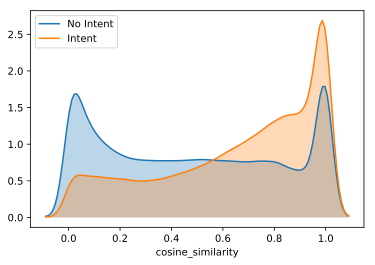

''

<Figure size 432x288 with 0 Axes>

In [36]:
ax = sns.distplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 0, 'cosine_similarity'], 
             hist=False, 
             label = 'No Intent')
ax = sns.distplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 1, 'cosine_similarity'], 
             hist=False,
             label = 'Intent')

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, alpha=0.3)
ax.fill_between(x2,y2, alpha=0.3)

plt.show()

plt.savefig('../docs/img/Cosine_sim.png')
;

In [30]:
train_df.loc[(train_df['is_duplicate'] == 1) & (train_df['id'] == 15), 'question1'].values

array(['What would a Trump presidency mean for current international master’s students on an F1 visa?'],
      dtype=object)

In [31]:
train_df.loc[(train_df['is_duplicate'] == 1) & (train_df['id'] == 15), 'question2'].values

array(['How will a Trump presidency affect the students presently in US or planning to study in US?'],
      dtype=object)